This notebook is used for training an LSTM model to predict the Remaining Useful Life (RUL) of turbofan engines based on simulated sensor data.

In [1]:
import glob
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Set for reproducability
np.random.seed(101)  
PYTHONHASHSEED = 0

import tensorflow as tf
import keras
from keras.optimizers import Adam
from keras.callbacks import TensorBoard, ModelCheckpoint, EarlyStopping, LearningRateScheduler
from keras.models import Sequential, load_model
from keras.layers import Dense, Dropout, LSTM, GRU, Masking, Activation, RepeatVector, TimeDistributed

from sklearn.pipeline import Pipeline
from sklearn import preprocessing
from sklearn.metrics import confusion_matrix, recall_score, precision_score

from data_generator import TSDataGenerator, split_data, create_generators
from util import set_log_dir, rmse
from util import LRDecay

from tqdm import tqdm, tqdm_notebook


Using TensorFlow backend.


In [2]:
DATA_DIR = os.path.abspath("./data/")
MODEL_DIR = os.path.abspath("./model/")

persist_run_stats = True # Enable for saving results to CouchDB

### Load Data

The data used for this project is the NASA C-MAPSS Turbofan Engine Degradation Data Set https://ti.arc.nasa.gov/c/6/.  This data is model based simulated data from the Commercial Modular Aero-Propulsion System Simulation (C-MAPSS).

In [3]:
!ls {DATA_DIR}

 CMAPSSDATA.zip			    RUL_FD004.txt    train.csv
'Damage Propagation Modeling.pdf'   test_FD001.txt   train_FD001.txt
 README.md			    test_FD002.txt   train_FD002.txt
 readme.txt			    test_FD003.txt   train_FD003.txt
 RUL_FD001.txt			    test_FD004.txt   train_FD004.txt
 RUL_FD002.txt			    test_x.csv
 RUL_FD003.txt			    test_y.csv


The data set is a multivariate time series. Each entry (row) reflects an operational cycle of a specific engine identified by engine id and cycle time. There are multiple entries per engine to represent different reporting times. Other columns represents different features 3 operational settings and 21 sensors:

<pre>
    1)      engine id
    2)      time, in cycles
    3)      operational setting 1
    4)      operational setting 2
    5)      operational setting 3
    6)      sensor measurement  1
    7)      sensor measurement  2
    ...
    26)     sensor measurement  21
</pre>

In [4]:
cols = ['id', 'cycle' ]

# Three operational setting columns
setting_cols = ['setting' + str(i) for i in range(1,4)]
cols.extend(setting_cols)

# Twenty one sensor columns
sensor_cols = ['s' + str(i) for i in range(1,22)]
cols.extend(sensor_cols)

sort_cols = ['id','cycle']


The CMAPSS data is divided into training, test, and RUL data files. Each of these is further partitioned in 4 subsets that represents a different operational condition. The number of engines in each vary.

In [5]:

fn_id_map = {
    "train_FD001": 1000,
    "train_FD002": 2000,
    "train_FD003": 3000,
    "train_FD004": 4000,
    "test_FD001":  5000,
    "test_FD002":  6000,
    "test_FD003":  7000,
    "test_FD004":  8000,    
    "RUL_FD001":  5000,
    "RUL_FD002":  6000,
    "RUL_FD003":  7000,
    "RUL_FD004":  8000, 
}


# Filename is mapped to a condition. Map:
#       ONE (Sea Level) to 0
#       SIX to 1
fn_condition_map = {
    "train_FD001": 1,
    "train_FD002": 2,
    "train_FD003": 1,
    "train_FD004": 2,
    "test_FD001":  1,
    "test_FD002":  2,
    "test_FD003":  1,
    "test_FD004":  2,    
}

In [6]:

def load_data(paths, col_names, sort_cols):
    # read data 
    df = pd.DataFrame()
    for p in paths:
        instance_df = pd.read_csv(p, sep=" ", header=None)
        instance_df.drop(instance_df.columns[[26, 27]], axis=1, inplace=True)
        instance_df.columns = col_names
        instance_df['filename'] = os.path.splitext(os.path.basename(p))[0]
        
        df = pd.concat((df, instance_df), sort=False) 

    df['condition'] = df['filename'].apply( lambda f: fn_condition_map[f])
    df['id'] = df['id'] + df['filename'].apply( lambda f: fn_id_map[f])
    df.drop(['filename'], axis=1, inplace=True)
    df = df.sort_values(sort_cols)
    return df

Read training, validation, and test data 


In [7]:
path = os.path.join(DATA_DIR, "train_FD*.txt")
all_files = glob.glob(path)

train_df = load_data(all_files, cols, sort_cols)
print("Train: ", train_df.shape)


Train:  (160359, 27)


In [8]:
train_df.head()

,id,cycle,setting1,setting2,setting3,s1,s2,s3,s4,s5,...,s13,s14,s15,s16,s17,s18,s19,s20,s21,condition
0,1001,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190,1
1,1001,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236,1
2,1001,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442,1
3,1001,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,...,2388.08,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739,1
4,1001,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,...,2388.04,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044,1


---
## Data Preparation

Two step process. First step is to calculate the Remaining Useful Life (RUL) that will be used as the label. The calculation different when using training or test files. Second, the data will be transformed using a min/max scaler.

### Calculate Training Data RUL

In [9]:
def calc_training_rul(df):
    # Data Labeling - generate column RUL
    rul = pd.DataFrame(df.groupby('id')['cycle'].max()).reset_index()
    rul.columns = ['id', 'max']
    df = df.merge(rul, on=['id'], how='left')
    df['RUL'] = df['max'] - df['cycle']
    df.drop('max', axis=1, inplace=True)
    return df

In [10]:
train_df = calc_training_rul(train_df)
train_df.head()

,id,cycle,setting1,setting2,setting3,s1,s2,s3,s4,s5,...,s14,s15,s16,s17,s18,s19,s20,s21,condition,RUL
0,1001,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190,1,191
1,1001,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236,1,190
2,1001,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442,1,189
3,1001,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,...,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739,1,188
4,1001,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,...,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044,1,187



### Data Transform

All transforms will be done using a pipeline. At this time only the min_max scalar is used.

In [11]:
pipeline = Pipeline(steps=[
    # The default activation function for LSTM tanh, so we'll use a range of [-1,1].
    ('min_max_scaler', preprocessing.MinMaxScaler(feature_range=(-1, 1)))
])

Transform training data.

In [12]:
# Set up the columns that will be scaled
train_df['cycle_norm'] = train_df['cycle']

# Transform all columns except id, cycle, and RUL
cols_transform = train_df.columns.difference(['id','cycle', 'RUL'])

xform_train_df = pd.DataFrame(pipeline.fit_transform(train_df[cols_transform]), 
                             columns=cols_transform, 
                             index=train_df.index)
join_df = train_df[train_df.columns.difference(cols_transform)].join(xform_train_df)
train_df = join_df.reindex(columns = train_df.columns)
train_df.head()

/home/saad/anaconda3/envs/tf/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


,id,cycle,setting1,setting2,setting3,s1,s2,s3,s4,s5,...,s15,s16,s17,s18,s19,s20,s21,condition,RUL,cycle_norm
0,1001,1,-0.999619,-0.999525,1.0,1.0,0.939980,0.854585,0.804223,1.0,...,-0.819144,1.0,0.836735,1.0,1.0,0.944164,0.940747,-1.0,191,-1.00000
1,1001,2,-0.999495,-0.999288,1.0,1.0,0.946000,0.865915,0.816384,1.0,...,-0.810692,1.0,0.836735,1.0,1.0,0.940128,0.941260,-1.0,190,-0.99631
2,1001,3,-0.999791,-0.997864,1.0,1.0,0.949649,0.845447,0.821459,1.0,...,-0.820312,1.0,0.795918,1.0,1.0,0.936764,0.932408,-1.0,189,-0.99262
3,1001,4,-0.999553,-0.998576,1.0,1.0,0.949649,0.817657,0.810304,1.0,...,-0.854394,1.0,0.836735,1.0,1.0,0.932055,0.935719,-1.0,188,-0.98893
4,1001,5,-0.999676,-0.999051,1.0,1.0,0.950014,0.817978,0.831131,1.0,...,-0.812341,1.0,0.857143,1.0,1.0,0.933401,0.939119,-1.0,187,-0.98524


---
## Model

Identify the columns that will be used for features and labels.

In [13]:
# Build the feature column list 
feature_cols = ['cycle_norm', 'condition']

# Three operational setting columns
setting_cols = ['setting' + str(i) for i in range(1,4)]
feature_cols.extend(setting_cols)

# Twenty one sensor columns
sensor_cols = ['s' + str(i) for i in range(1,22)]
feature_cols.extend(sensor_cols)

# Build the label column list
label_cols = ['RUL']

### LSTM Network
The model is an LSTM network. The first layer is an LSTM layer with 128 units followed by a set of Dense layers with 64, 32, and 1 units respectively. 

[Keras LSTM](https://keras.io/layers/recurrent/) layers expect an input in the shape of a numpy array of 3 dimensions (samples, time steps, features) where samples is the number of training sequences, time steps is the look back window or sequence length and features is the number of features of each sequence at each time step. 

The LSTM layer is followed by three Dense layers with 64, 32 and finally 1 unit. All use a RELU activation function.

An Adam optimizer is used and Root Mean Squared Error (RMSE) is used for the loss function:

\begin{equation}
    RMSE = \sqrt{ \frac{1}{n} \sum_{i=1}^{n} (\hat{y}^i-RUL^i)^2 }
\end{equation}

Mean Squared Error (MSE) and Mean Absolute Error (MAE) are also tracked as metrics.


In [14]:

def create_model(batch_size, seq_length, num_features, num_labels):
    # build the network

    model = Sequential()

    model.add(Masking(mask_value=0., input_shape=(sequence_length, num_features)))

    model.add(LSTM(
             input_shape=(sequence_length, num_features),
             units=128,
             batch_input_shape=(batch_size, sequence_length, num_features),
             stateful=False,
             dropout=0.05,
             return_sequences=False))

    model.add(Dense(units=64, activation='relu'))
    model.add(Dense(units=32, activation='relu'))
    model.add(Dense(units=num_labels, activation='relu'))
    
    return model


In [15]:
# Size of the series time window.
sequence_length = 25

# Number of time series sequences that will be train on per batch.
batch_size = 512

num_features = len(feature_cols)
num_labels = len(label_cols)

# Create the model
model = create_model(batch_size, sequence_length, num_features, num_labels)

opt = Adam(lr=1e-3, decay=0.0, amsgrad=True)
model.compile(loss=rmse, optimizer=opt, metrics=['mse', 'mae'])

In [16]:
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
masking_1 (Masking)          (None, 25, 26)            0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 128)               79360     
_________________________________________________________________
dense_1 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_2 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 33        
Total params: 89,729
Trainable params: 89,729
Non-trainable params: 0
_________________________________________________________________
None


---
## Train

In [17]:
# Setup log directory
log_dir, checkpoint_path = set_log_dir(MODEL_DIR, "engine")

print("Log dir: ", log_dir)
print("Checkpoint path: ", checkpoint_path)

# Save the pipeline for later use
from sklearn.externals import joblib 
pipeline_path = os.path.join(log_dir, 'engine_pipeline.pkl') 
joblib.dump(pipeline, pipeline_path) 

Log dir:  /home/saad/workspaces/predictive-maintenance-lstm/model/engine20190122T0916
Checkpoint path:  /home/saad/workspaces/predictive-maintenance-lstm/model/engine20190122T0916/engine_model.h5


['/home/saad/workspaces/predictive-maintenance-lstm/model/engine20190122T0916/engine_pipeline.pkl']

In [18]:
training_runs = 4
num_epochs = 200
initial_epoch = 0
epochs_before_decay = 15
lrate = 1e-3
patience = 10
    
tensorboard = TensorBoard(log_dir=log_dir,
                        histogram_freq=0, write_graph=True, write_images=False)

checkpointer = ModelCheckpoint(checkpoint_path, verbose=1, save_best_only=True)

epoch_loss_history = []
epoch_val_history = []
epoch_lr_history = []

for tr_run in range(training_runs):

    print("Training run: {}, epoch: {}".format(tr_run, initial_epoch))

    t_df, v_df = split_data(train_df, randomize=True, train_pct=.8)
    train_data_generator, val_data_generator = create_generators(t_df, v_df, 
                                                                 feature_cols, 
                                                                 label_cols, 
                                                                 batch_size=batch_size, 
                                                                 sequence_length=sequence_length, 
                                                                 randomize=True, 
                                                                 loop=True,
                                                                 pad=False,
                                                                 verbose=True)
       
    # Callbacks
    lr_decay = LRDecay(initial_lrate=lrate, epochs_step=epochs_before_decay)
    lr_scheduler = LearningRateScheduler(lr_decay.step_decay, verbose=1)
    
    earlystopper = EarlyStopping(patience=patience, verbose=1)
    
    callbacks = [ tensorboard, checkpointer, lr_scheduler, earlystopper]

    # fit the network
    history = model.fit_generator(
        generator=train_data_generator.generate(), 
        validation_data=val_data_generator.generate(), 
        initial_epoch=initial_epoch,
        epochs=num_epochs, 
        steps_per_epoch=train_data_generator.summary()['max_iterations'],
        validation_steps=val_data_generator.summary()['max_iterations'],
        shuffle=False,
        verbose=1,
        callbacks=callbacks )
    
    # pick up after the last epoch
    if len(history.epoch) > 0:        
        initial_epoch = history.epoch[-1] + 1
    
    # TODO fix, sometimes Keras is returning an empty history dict.
    try:
        # Save loss/val metrics
        epoch_loss_history += history.history['loss']
        epoch_val_history += history.history['val_loss']
        epoch_lr_history += lr_decay.history_lr
    except:
        pass
    
    # reduce starting lr as we iterate into another training loop
    #lrate /= 10
    
    print("Loading previous best weights: ", checkpoint_path)
    model.load_weights(checkpoint_path)
    

Training run: 0, epoch: 0
Engine split: Training=0.80, Validation=0.20
Cycle split:  Training=0.79, Validation=0.21
Number of items:  567
Undersized items:  0
Data shape:  (127034, 29)
Max steps:  113426
Max iterations: 221 @ 512
Number of items:  142
Undersized items:  0
Data shape:  (33325, 29)
Max steps:  29917
Max iterations: 58 @ 512
Epoch 1/200

Epoch 00001: LearningRateScheduler setting learning rate to 0.001.
221/221 [==============================] - 175s 790ms/step - loss: 82.7410 - mean_squared_error: 7828.9939 - mean_absolute_error: 68.3616 - val_loss: 80.9200 - val_mean_squared_error: 7356.1490 - val_mean_absolute_error: 65.7779

Epoch 00001: val_loss improved from inf to 80.91996, saving model to /home/saad/workspaces/predictive-maintenance-lstm/model/engine20190122T0916/engine_model.h5
Epoch 2/200

Epoch 00002: LearningRateScheduler setting learning rate to 0.001.
221/221 [==============================] - 169s 766ms/step - loss: 73.4294 - mean_squared_error: 6116.0378 -


Epoch 00039: val_loss did not improve from 49.22382
Epoch 40/200

Epoch 00040: LearningRateScheduler setting learning rate to 0.001.
223/223 [==============================] - 170s 762ms/step - loss: 49.9364 - mean_squared_error: 3278.7989 - mean_absolute_error: 39.7868 - val_loss: 55.8622 - val_mean_squared_error: 3802.4901 - val_mean_absolute_error: 47.0354

Epoch 00040: val_loss did not improve from 49.22382
Epoch 41/200

Epoch 00041: LearningRateScheduler setting learning rate to 0.001.
223/223 [==============================] - 171s 767ms/step - loss: 50.2608 - mean_squared_error: 3228.0728 - mean_absolute_error: 40.2343 - val_loss: 52.3863 - val_mean_squared_error: 3343.8958 - val_mean_absolute_error: 43.5816

Epoch 00041: val_loss did not improve from 49.22382
Epoch 42/200

Epoch 00042: LearningRateScheduler setting learning rate to 0.001.
223/223 [==============================] - 171s 767ms/step - loss: 49.5806 - mean_squared_error: 3164.7433 - mean_absolute_error: 39.8622 - 

223/223 [==============================] - 171s 767ms/step - loss: 49.7509 - mean_squared_error: 3230.8675 - mean_absolute_error: 40.1815 - val_loss: 45.7048 - val_mean_squared_error: 2877.0496 - val_mean_absolute_error: 35.4414

Epoch 00060: val_loss did not improve from 41.53640
Epoch 61/200

Epoch 00061: LearningRateScheduler setting learning rate to 0.001.
223/223 [==============================] - 170s 762ms/step - loss: 50.0737 - mean_squared_error: 3236.2220 - mean_absolute_error: 40.0612 - val_loss: 43.6050 - val_mean_squared_error: 2518.5998 - val_mean_absolute_error: 32.8914

Epoch 00061: val_loss did not improve from 41.53640
Epoch 62/200

Epoch 00062: LearningRateScheduler setting learning rate to 0.001.
223/223 [==============================] - 171s 768ms/step - loss: 50.7214 - mean_squared_error: 3337.8501 - mean_absolute_error: 40.7784 - val_loss: 44.0467 - val_mean_squared_error: 2568.8256 - val_mean_absolute_error: 33.9893

Epoch 00062: val_loss did not improve from 4


Epoch 00081: val_loss did not improve from 39.60961
Epoch 82/200

Epoch 00082: LearningRateScheduler setting learning rate to 0.00049067.
223/223 [==============================] - 171s 767ms/step - loss: 47.2630 - mean_squared_error: 2964.6351 - mean_absolute_error: 37.3166 - val_loss: 40.1976 - val_mean_squared_error: 2184.6751 - val_mean_absolute_error: 31.4182

Epoch 00082: val_loss did not improve from 39.60961
Epoch 83/200

Epoch 00083: LearningRateScheduler setting learning rate to 0.00049067.
223/223 [==============================] - 171s 766ms/step - loss: 46.7734 - mean_squared_error: 2884.1777 - mean_absolute_error: 37.2751 - val_loss: 39.8123 - val_mean_squared_error: 2192.6067 - val_mean_absolute_error: 30.2782

Epoch 00083: val_loss did not improve from 39.60961
Epoch 84/200

Epoch 00084: LearningRateScheduler setting learning rate to 0.00049067.
223/223 [==============================] - 170s 763ms/step - loss: 46.7485 - mean_squared_error: 2845.9328 - mean_absolute_er

223/223 [==============================] - 171s 768ms/step - loss: 43.8983 - mean_squared_error: 2576.5037 - mean_absolute_error: 34.5217 - val_loss: 41.5556 - val_mean_squared_error: 2175.1995 - val_mean_absolute_error: 34.1130

Epoch 00103: val_loss did not improve from 36.69451
Epoch 104/200

Epoch 00104: LearningRateScheduler setting learning rate to 0.00011101.
223/223 [==============================] - 170s 761ms/step - loss: 45.0925 - mean_squared_error: 2701.5656 - mean_absolute_error: 35.6956 - val_loss: 38.9283 - val_mean_squared_error: 1909.2236 - val_mean_absolute_error: 31.1378

Epoch 00104: val_loss did not improve from 36.69451
Epoch 00104: early stopping
Loading previous best weights:  /home/saad/workspaces/predictive-maintenance-lstm/model/engine20190122T0916/engine_model.h5
Training run: 3, epoch: 104
Engine split: Training=0.80, Validation=0.20
Cycle split:  Training=0.80, Validation=0.20
Number of items:  567
Undersized items:  0
Data shape:  (128641, 29)
Max steps:

Plot the training and validation loss across all runs overlayed with the learning rate used.

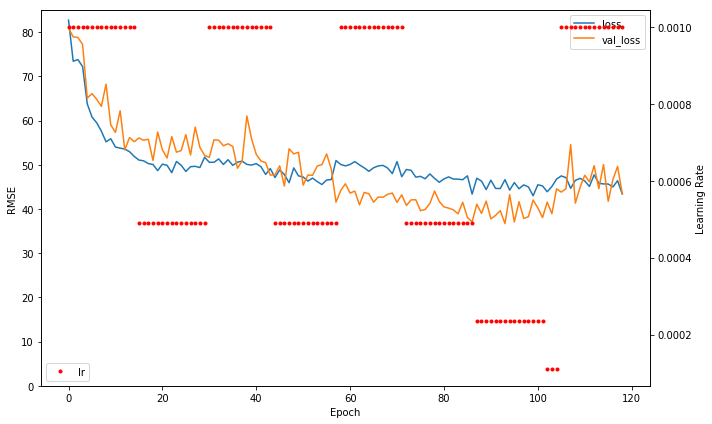

In [19]:
fig, ax1 = plt.subplots(figsize=(10,6))

epochs = np.arange(len(epoch_loss_history))
ax1.plot(epochs, epoch_loss_history, label='loss')
ax1.plot(epochs, epoch_val_history, label='val_loss')
ax1.set_xlabel("Epoch")
ax1.set_ylabel("RMSE")
ax1.set_ylim(0)
ax1.legend()

# Add a rhs scale for the LR.
ax2 = ax1.twinx()
lr_epochs = []
lr_steps = []

for e1, l1, l2 in epoch_lr_history:
    lr_epochs.append(e1)
    lr_steps.append(l1)


ax2.plot(lr_epochs, lr_steps, 'r.', label='lr')
ax2.set_ylabel("Learning Rate")
ax2.legend(loc='lower left')

fig.tight_layout()
plt.show()

---
## Test

Loading and pre-processing the test data is similar to how validation data was handled.


#### Load Model

Reload the latest, best model from this run.

In [20]:
print("Loading model: ", checkpoint_path)
custom_objects={'rmse':rmse}
inf_model = load_model(checkpoint_path, custom_objects=custom_objects)

inf_model.summary()

Loading model:  /home/saad/workspaces/predictive-maintenance-lstm/model/engine20190122T0916/engine_model.h5
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
masking_1 (Masking)          (None, 25, 26)            0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 128)               79360     
_________________________________________________________________
dense_1 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_2 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 33        
Total params: 89,729
Trainable params: 89,729
Non-trainable params: 0
_________________________________________________________________


#### Load prepare test data

Calculating RUL for test data is a bit more involved. For evaluation we'll be using the data from the test_FD003.txt files and the corresponding RUL_FD003.txt for the actual RUL ground truth. This allows us to utilize more data for training. The key calculation difference is that the last cycle in the these files must equal the ground truth RUL. Therefore we compute the RUL for each entry by working backwards from the last cycle entry.

In [21]:
dataset_name = 'FD003'

test_X_path = os.path.join(DATA_DIR, 'test_' + dataset_name + '.txt')
test_y_path = os.path.join(DATA_DIR, 'RUL_' + dataset_name + '.txt')

In [22]:

def load_rul_data(paths, col_names):
    
    # Filename is used to determine the condition
    col_names.append('filename')

    # read data 
    df = pd.DataFrame()
    for p in paths:
        instance_df = pd.read_csv(p, sep=" ", header=None)
        instance_df.drop(instance_df.columns[[1]], axis=1, inplace=True)
        instance_df['filename'] = os.path.splitext(os.path.basename(p))[0]
        instance_df = instance_df.reset_index()
        instance_df.columns = col_names
        
        df = pd.concat((df, instance_df), sort=False) 

    df['id'] = df['id'] + df['filename'].apply( lambda f: fn_id_map[f]) + 1
    df.drop(['filename'], axis=1, inplace=True)
    return df



In [23]:
def calc_test_rul( feature_df, label_df):
    # If index is not reset there will be int/str type issues when attempting the merge. 
    cycle_count_df = feature_df.groupby('id').count().reset_index()[['id','cycle']].rename(index=str, columns={"cycle":"cycles"}).reset_index(drop=True)
    print(cycle_count_df.shape)

    # Join cycle and RUL dataframes
    assert cycle_count_df.shape[0] == label_df.shape[0]
    tmp_df = cycle_count_df.merge(label_df, on="id", how='left')

    # The RUL actual column contains the value for the last cycle.
    # Adding the cycles column will give us the RUL for the first cycle.
    tmp_df['RUL_actual'] = tmp_df['cycles'] + tmp_df['RUL_actual']
    tmp_df.drop('cycles',  axis=1, inplace=True)

    # Join the two data frames
    feature_df = feature_df.merge(tmp_df, on='id', how='left')


    # Use the cycle to decrement the RUL until the ground truth is reached.
    feature_df['RUL'] = feature_df['RUL_actual'] - feature_df['cycle']
    feature_df.drop('RUL_actual',  axis=1, inplace=True)
    
    return feature_df


In [24]:
# Read in the features
test_df = load_data([test_X_path], cols, sort_cols)

# Read in the labels (RUL)
test_rul_df = load_rul_data([test_y_path], ['id', 'RUL_actual'])

# Calculate the RUL and merge back to the test dataframe
test_df = calc_test_rul(test_df, test_rul_df)
test_df.head()


(100, 2)


,id,cycle,setting1,setting2,setting3,s1,s2,s3,s4,s5,...,s14,s15,s16,s17,s18,s19,s20,s21,condition,RUL
0,7001,1,-0.0017,-0.0004,100.0,518.67,641.94,1581.93,1396.93,14.62,...,8133.48,8.3760,0.03,391,2388,100.0,39.07,23.4468,1,276
1,7001,2,0.0006,-0.0002,100.0,518.67,642.02,1584.86,1398.90,14.62,...,8137.44,8.4062,0.03,391,2388,100.0,39.04,23.4807,1,275
2,7001,3,0.0014,-0.0003,100.0,518.67,641.68,1581.78,1391.92,14.62,...,8138.25,8.3553,0.03,391,2388,100.0,39.10,23.4244,1,274
3,7001,4,0.0027,0.0001,100.0,518.67,642.20,1584.53,1395.34,14.62,...,8137.07,8.3709,0.03,392,2388,100.0,38.97,23.4782,1,273
4,7001,5,-0.0001,0.0001,100.0,518.67,642.46,1589.03,1395.86,14.62,...,8134.20,8.4146,0.03,391,2388,100.0,39.09,23.3950,1,272


Transform test data

In [25]:

test_df['cycle_norm'] = test_df['cycle']

norm_test_df = pd.DataFrame(pipeline.transform(test_df[cols_transform]), 
                            columns=cols_transform, 
                            index=test_df.index)
test_join_df = test_df[test_df.columns.difference(cols_transform)].join(norm_test_df)
test_df = test_join_df.reindex(columns = test_df.columns)
test_df = test_df.reset_index(drop=True)

In [26]:
test_df.head()[feature_cols]

,cycle_norm,condition,setting1,setting2,setting3,s1,s2,s3,s4,s5,...,s12,s13,s14,s15,s16,s17,s18,s19,s20,s21
0,-1.00000,-1.0,-0.999667,-0.999525,1.0,1.0,0.942169,0.813061,0.786651,1.0,...,0.923750,0.985947,0.284547,-0.849035,1.0,0.816327,1.0,1.0,0.944837,0.943846
1,-0.99631,-1.0,-0.999557,-0.999051,1.0,1.0,0.943629,0.828720,0.796084,1.0,...,0.923554,0.986333,0.302228,-0.828283,1.0,0.816327,1.0,1.0,0.942819,0.947625
2,-0.99262,-1.0,-0.999519,-0.999288,1.0,1.0,0.937426,0.812260,0.762664,1.0,...,0.924776,0.985947,0.305845,-0.863258,1.0,0.816327,1.0,1.0,0.946855,0.941349
3,-0.98893,-1.0,-0.999457,-0.998338,1.0,1.0,0.946912,0.826956,0.779039,1.0,...,0.926487,0.986058,0.300576,-0.852539,1.0,0.836735,1.0,1.0,0.938110,0.947347
4,-0.98524,-1.0,-0.999591,-0.998338,1.0,1.0,0.951656,0.851005,0.781528,1.0,...,0.923848,0.986113,0.287762,-0.822511,1.0,0.816327,1.0,1.0,0.946182,0.938071


In [27]:
test_df.head()[label_cols]

,RUL
0,276
1,275
2,274
3,273
4,272


#### Evaluate

Collect metrics across then entire test sample.

In [28]:
test_data_generator = TSDataGenerator(test_df, 
                                      feature_cols, 
                                      label_cols,
                                      batch_size=batch_size,
                                      seq_length=sequence_length, 
                                      randomize=False,
                                      loop=False)
test_data_generator.print_summary()

X = []
y = []
for p in tqdm_notebook(test_data_generator.generate(), total=test_data_generator.summary()['max_iterations']):
    X.append(p[0])
    y.append(p[1])

test_X = np.vstack(X)
test_y = np.vstack(y)


Number of items:  100
Undersized items:  0
Data shape:  (16596, 29)
Max steps:  14196
Max iterations: 27 @ 512


In [29]:
# Evaluation metrics are RMSE, MSE, MAE
score = inf_model.evaluate(test_X, test_y, verbose=1, batch_size=batch_size)
print('Test score:\n\tRMSE: {}\n\tMSE: {}\n\tMAE: {}'.format(*score))

13824/13824 [==============================] - 0s 28us/step
Test score:
	RMSE: 60.54784216704192
	MSE: 4545.844335485388
	MAE: 47.62541029188368


Predict on one batch from the test data. This is a fragment of the data.

In [30]:
test_data_generator = TSDataGenerator(test_df, feature_cols, label_cols, batch_size=batch_size, seq_length=sequence_length, loop=False)

g = test_data_generator.generate()
test_X, test_y = next(g)
y_pred_array = inf_model.predict_on_batch(test_X)

In [31]:
def plot_prediction(rul_actual, rul_predicted):  
    fig = plt.figure(figsize=(25,5))
    cycles = np.arange(len(rul_actual))
    plt.scatter(cycles, rul_predicted, marker='.', label="Predicted")
    plt.plot(cycles, rul_actual, 'r', label="Actual")
    plt.xlabel("Cycle")
    plt.xlim(0)
    plt.ylabel("RUL")
    plt.ylim(0)

    plt.legend()
    plt.show()

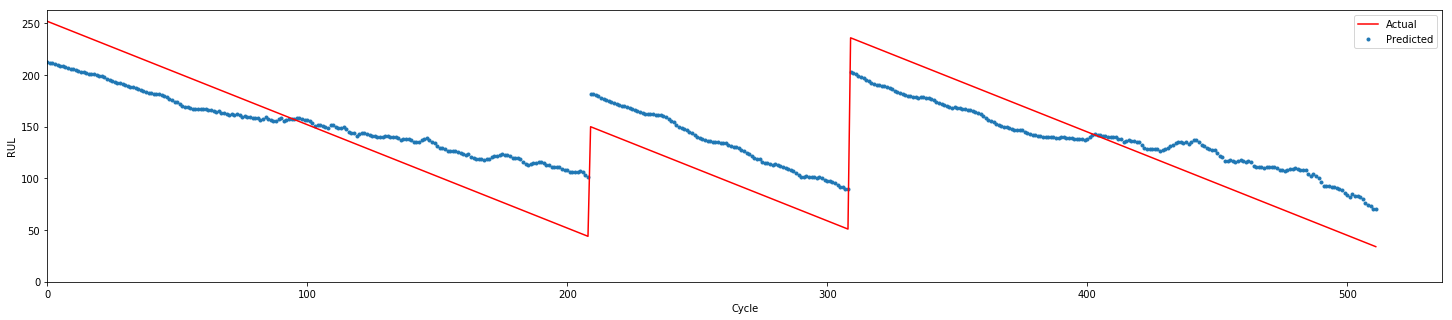

In [32]:
plot_prediction(test_y, y_pred_array)

The above plot shows the first batch. As the sequence approaches the last time series entry, the prediction converged closeer to the actual RUL. Running a second batch gives us:

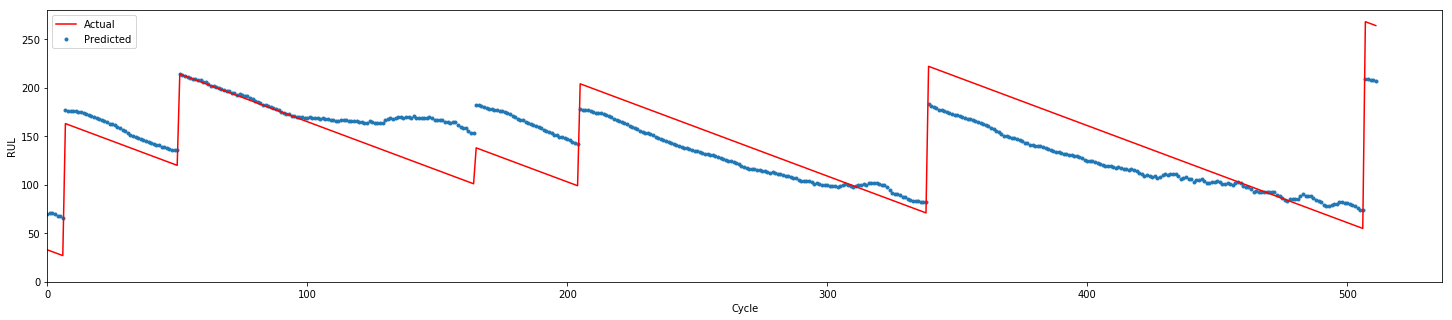

In [33]:
test_X, test_y = next(g)
y_pred_array = inf_model.predict_on_batch(test_X)
plot_prediction(test_y, y_pred_array)

---

## Persist

Save parameters and results (requires couchdb and client)

In [40]:
if persist_run_stats:
    print("Persisting training run.")
    import sys
    import os
    sys.path.append(os.path.abspath('../ml_utils'))
    import ml_utils

    username = os.getenv('COUCHDB_USER')
    password = os.getenv('COUCHDB_PASSWORD')
    
    db_helper = ml_utils.couchdb.CouchDBHelper("engine", username, password)
    db_helper.connect()

    payload = {
        'score': score,
        'model': inf_model.to_json(),
        'epoch_lr_history': epoch_lr_history,
        'epoch_loss_history': epoch_loss_history,
        'epoch_val_history': epoch_val_history
    }

    db_helper.save(os.path.basename(log_dir), payload)
    db_helper.disconnect()
else:
    print("Not persisting training run.")


Persisting training run.


In [36]:
# This is to prevent overwrites
persist_run_stats = False